In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# Notebook: OverlappingT263withHUVEC.ipynb
# Purpose:
#   Part 1) Extract mtRNA-associated DNA-end sites from iMARGI .pairs.gz,
#            merge nearby sites (±250 bp), and write per-sample BED files.
#   Part 2) Compute and visualize overlap between NCOR/GPS2 TF peaks and
#            these mtRNA-binding regions.
#   Part 3) Perform Fisher’s exact tests on overlap counts:
#            • Intra-group (same condition across timepoints)
#            • Inter-group (different conditions at same timepoint)
# ─────────────────────────────────────────────────────────────────────────────


# This script extracts DNA-end sites associated with mtRNA (chrM) from iMARGI .pairs.gz files,
# merges nearby sites (±250 bp), and saves them as BED files for each sample.

# Cell 1: Extract mtRNA-binding DNA sites and save as BED
import gzip
import pybedtools
import os

# Paths to iMARGI .pairs.gz files
pairs_files = {
    "Control": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900120.pairs.gz",
    "HG+TNFα Day3": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900121.pairs.gz",
    "HG+TNFα Day7": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900122.pairs.gz"
}

# Output directory for merged mtRNA sites
outdir = "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis"
os.makedirs(outdir, exist_ok=True)

for name, pairs_file in pairs_files.items():
    dna_sites = []
    # Read compressed .pairs.gz line by line
    with gzip.open(pairs_file, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue  # Skip header/comment lines
            cols = line.strip().split("\t")
            rna_chr = cols[1]       # RNA-end chromosome
            dna_chr = cols[3]       # DNA-end chromosome
            dna_pos = int(cols[4])  # DNA-end position

            # Keep only pairs where RNA-end is mitochondrial
            if rna_chr in ["chrM", "chrMT", "MT"]:
                # Record a 1-bp interval at the DNA-end site
                dna_sites.append([dna_chr, dna_pos, dna_pos + 1])

    if not dna_sites:
        print(f"{name}: No mtRNA-binding read pairs found!")
        continue

    # Merge intervals within ±250 bp (i.e., max gap = 500 bp)
    dna_bed = pybedtools.BedTool(dna_sites).sort().merge(d=500)
    
    # Save merged intervals as BED
    outfile = os.path.join(outdir, f"mtRNA_DNA_sites_{name}.bed")
    dna_bed.saveas(outfile)
    print(f"{name}: Generated {outfile}, regions = {len(dna_bed)}")



KeyboardInterrupt: 

In [ ]:
#Overlap with HUVEC


=== siCTL: total peaks = 36406 ===
siCTL - Control: overlap = 2390, 6.56%
siCTL - HG+TNFα Day3: overlap = 3004, 8.25%
siCTL - HG+TNFα Day7: overlap = 3613, 9.92%

=== siGPS2: total peaks = 9302 ===
siGPS2 - Control: overlap = 513, 5.51%
siGPS2 - HG+TNFα Day3: overlap = 639, 6.87%
siGPS2 - HG+TNFα Day7: overlap = 757, 8.14%

=== GPS2: total peaks = 33437 ===
GPS2 - Control: overlap = 3116, 9.32%
GPS2 - HG+TNFα Day3: overlap = 4174, 12.48%
GPS2 - HG+TNFα Day7: overlap = 4941, 14.78%

=== Overlap statistics ===
Condition       Sample  Total peaks  Overlap count  Percentage (%)
    siCTL      Control        36406           2390        6.564852
    siCTL HG+TNFα Day3        36406           3004        8.251387
    siCTL HG+TNFα Day7        36406           3613        9.924188
   siGPS2      Control         9302            513        5.514943
   siGPS2 HG+TNFα Day3         9302            639        6.869490
   siGPS2 HG+TNFα Day7         9302            757        8.138035
     GPS2      C

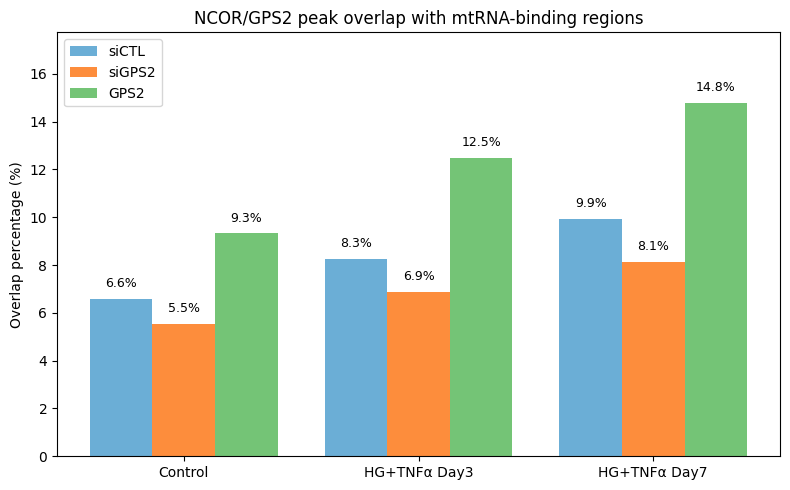

In [ ]:
# Cell 2: Overlap mtRNA sites with NCOR/GPS2 peaks and plot percentages
import pybedtools
import pandas as pd
import matplotlib.pyplot as plt

# === Input BEDs ===
mtRNA_files = {
    "Control": f"{outdir}/mtRNA_DNA_sites_Day0.bed",
    "HG+TNFα Day3": f"{outdir}/mtRNA_DNA_sites_Day3.bed",
    "HG+TNFα Day7": f"{outdir}/mtRNA_DNA_sites_Day7.bed"
}

# TF peak BEDs for three conditions
peak_files = {
    "siCTL": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/T263/Peak_file/NCOR_siCTL_hg38.bed",
    "siGPS2": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/T263/Peak_file/NCOR_siGPS2_hg38.bed",
    "GPS2": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/T263/Peak_file/GPS2_minusTNFA_hg38.bed"
}

results_all = []
# Loop through each TF condition
for condition, peaks_path in peak_files.items():
    peaks_bed    = pybedtools.BedTool(peaks_path)
    total_peaks  = len(peaks_bed)  # Number of peaks in this condition
    print(f"\n=== {condition}: total peaks = {total_peaks} ===")

    # Compare against each mtRNA site set
    for day, mtRNA_path in mtRNA_files.items():
        mtRNA_bed  = pybedtools.BedTool(mtRNA_path)
        # Count peaks overlapping any mtRNA interval
        overlap    = peaks_bed.intersect(mtRNA_bed, u=True).count()
        percentage = (overlap / total_peaks * 100) if total_peaks else 0
        results_all.append([condition, day, total_peaks, overlap, percentage])
        print(f"{condition} - {day}: overlap = {overlap}, {percentage:.2f}%")

# Build DataFrame of overlap stats
df = pd.DataFrame(
    results_all,
    columns=["Condition", "Sample", "Total peaks", "Overlap count", "Percentage (%)"]
)
print("\n=== Overlap statistics ===")
print(df.to_string(index=False))

# Save stats to CSV
df.to_csv("NCOR_GPS2_mtRNA_overlap_stats.csv", index=False)

# Plot grouped bar chart of overlap percentages
plt.figure(figsize=(8, 5))
color_palette = {"siCTL": "#6baed6", "siGPS2": "#fd8d3c", "GPS2": "#74c476"}

# Number of mtRNA samples
n_days   = len(mtRNA_files)
conds    = list(peak_files.keys())
bar_width = 0.8 / len(conds)

for i, day in enumerate(mtRNA_files):
    for j, cond in enumerate(conds):
        pct = df.loc[(df["Condition"] == cond) & (df["Sample"] == day), "Percentage (%)"].values[0]
        # Compute bar position
        x = i + j * bar_width - 0.4 + bar_width/2
        plt.bar(x, pct, width=bar_width, color=color_palette[cond],
                label=cond if i == 0 else "")
        plt.text(x, pct + 0.5, f"{pct:.1f}%", ha="center", fontsize=9)

plt.xticks(range(n_days), mtRNA_files.keys())
plt.ylabel("Overlap percentage (%)")
plt.title("NCOR/GPS2 peak overlap with mtRNA-binding regions")
plt.ylim(0, df["Percentage (%)"].max() * 1.2)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Cell 3: Fisher’s Exact Tests for Overlap Proportions
from scipy.stats import fisher_exact
from itertools import combinations
import panda as pd
# Intra-group: compare timepoints within each condition
intra_results = []
print("\n=== Intra-group comparisons ===")
for cond in df["Condition"].unique():
    sub = df[df["Condition"] == cond].set_index("Sample")
    # Compare Day0 vs Day3, and Day3 vs Day7
    for d1, d2 in [("Day0","Day3"), ("Day3","Day7")]:
        if d1 in sub.index and d2 in sub.index:
            tot = sub.loc[d1, "Total peaks"]
            a = sub.loc[d1, "Overlap count"]
            b = tot - a
            c = sub.loc[d2, "Overlap count"]
            d = tot - c
            odds, p = fisher_exact([[a,b],[c,d]])
            print(f"{cond}: {d1} vs {d2} -> OR={odds:.2f}, p={p:.3e}")
            intra_results.append([cond, d1, d2, odds, p])

# Save intra results
pd.DataFrame(intra_results,
             columns=["Condition","Day1","Day2","Odds ratio","P-value"]) \
  .to_csv("Fisher_intra_group_results.csv", index=False)

# Inter-group: compare conditions at each timepoint
inter_results = []
print("\n=== Inter-group comparisons ===")
for day in df["Sample"].unique():
    sub_day = df[df["Sample"] == day].set_index("Condition")
    for c1, c2 in combinations(sub_day.index, 2):
        tot1 = sub_day.loc[c1, "Total peaks"]
        tot2 = sub_day.loc[c2, "Total peaks"]
        a = sub_day.loc[c1, "Overlap count"]
        b = tot1 - a
        c = sub_day.loc[c2, "Overlap count"]
        d = tot2 - c
        odds, p = fisher_exact([[a,b],[c,d]])
        print(f"{day}: {c1} vs {c2} -> OR={odds:.2f}, p={p:.3e}")
        inter_results.append([day, c1, c2, odds, p])

# Save inter results
pd.DataFrame(inter_results,
             columns=["Day","Condition1","Condition2","Odds ratio","P-value"]) \
  .to_csv("Fisher_inter_group_results.csv", index=False)

print("\nFisher test results saved.")


=== Intra-group comparisons (within each condition across time points) ===
siCTL: Day0 vs Day3 -> OR=0.78, P=3.870e-18
siCTL: Day3 vs Day7 -> OR=0.82, P=4.365e-15
siGPS2: Day0 vs Day3 -> OR=0.79, P=1.414e-04
siGPS2: Day3 vs Day7 -> OR=0.83, P=1.124e-03
GPS2: Day0 vs Day3 -> OR=0.72, P=2.054e-39
GPS2: Day3 vs Day7 -> OR=0.82, P=5.745e-18

=== Inter-group comparisons (between conditions at each time point) ===
Day0: siCTL vs siGPS2 -> OR=1.20, P=1.831e-04
Day0: siCTL vs GPS2 -> OR=0.68, P=2.014e-41
Day0: siGPS2 vs GPS2 -> OR=0.57, P=4.942e-34
Day3: siCTL vs siGPS2 -> OR=1.22, P=8.901e-06
Day3: siCTL vs GPS2 -> OR=0.63, P=1.210e-75
Day3: siGPS2 vs GPS2 -> OR=0.52, P=6.249e-57
Day7: siCTL vs siGPS2 -> OR=1.24, P=1.172e-07
Day7: siCTL vs GPS2 -> OR=0.64, P=4.518e-85
Day7: siGPS2 vs GPS2 -> OR=0.51, P=2.231e-68

=== Fisher's exact test results saved to CSVs ===



Regardless of whether GPS2 is knocked down, the overlap percentage between mtRNA-binding regions and NCOR peaks increases significantly as the treatment duration is extended.
  
The overlap between mtRNA-binding regions and NCOR peaks increases with longer high glucose + TNFα treatment, regardless of GPS2 knockdown

GPS2 knockdown greatly reduces this overlap (OR ≈ 5), indicating GPS2 is essential for maintaining the interaction between these regions

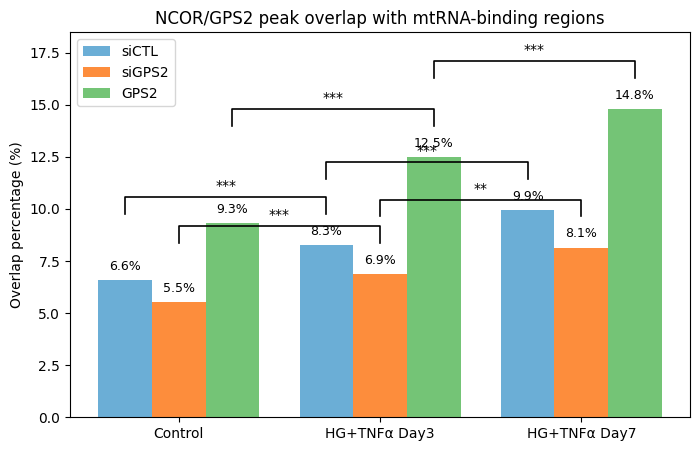

In [7]:
import matplotlib.pyplot as plt

# 绘图准备
plt.figure(figsize=(8, 5))
color_palette = {"siCTL": "#6baed6", "siGPS2": "#fd8d3c", "GPS2": "#74c476"}

days = list(mtRNA_files.keys())
conds = list(peak_files.keys())
bar_width = 0.8 / len(conds)

# 构建一个字典用于查百分比
pct_map = {
    (row["Sample"], row["Condition"]): row["Percentage (%)"]
    for _, row in df.iterrows()
}

# 绘制柱状图
for i, day in enumerate(days):
    for j, cond in enumerate(conds):
        pct = pct_map[(day, cond)]
        x = i + j * bar_width - 0.4 + bar_width / 2
        plt.bar(x, pct, width=bar_width, color=color_palette[cond],
                label=cond if i == 0 else "")
        plt.text(x, pct + 0.5, f"{pct:.1f}%", ha="center", fontsize=9)

plt.xticks(range(len(days)), days)
plt.ylabel("Overlap percentage (%)")
plt.title("NCOR/GPS2 peak overlap with mtRNA-binding regions")
plt.ylim(0, max(pct_map.values()) * 1.25)
plt.legend()

# 添加显著性标注（基于Fisher test结果）
def get_x(day, cond):
    return days.index(day) + conds.index(cond) * bar_width - 0.4 + bar_width/2

def p_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# === intra-group 显著性标注 ===
intra_group_results = [
    ("siCTL", "Control", "HG+TNFα Day3", 3.870e-18),
    ("siCTL", "HG+TNFα Day3", "HG+TNFα Day7", 4.365e-15),
    ("siGPS2", "Control", "HG+TNFα Day3", 1.414e-4),
    ("siGPS2", "HG+TNFα Day3", "HG+TNFα Day7", 1.124e-3),
    ("GPS2", "Control", "HG+TNFα Day3", 2.054e-39),
    ("GPS2", "HG+TNFα Day3", "HG+TNFα Day7", 5.745e-18),
]

for cond, d1, d2, p in intra_group_results:
    x1 = get_x(d1, cond)
    x2 = get_x(d2, cond)
    y = max(pct_map[(d1, cond)], pct_map[(d2, cond)]) + 1.5
    star = p_to_star(p)
    if star:
        plt.plot([x1, x1, x2, x2], [y, y+0.8, y+0.8, y], lw=1.2, c='black')
        plt.text((x1 + x2)/2, y + 1.0, star, ha='center', va='bottom', fontsize=10)
